In [1]:
# Imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import utilities
import os
import time

# import data visualization
import matplotlib.pyplot as plt

# import pytorch
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.data import random_split


from torchsummary import summary

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
# define transformations for train
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=.40),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# define transformations for test
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [4]:
batch_size = 64

In [5]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=train_transform)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=test_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


View some random images from the training dataset:

In [6]:
# specify the names of the classes
classes_dict = {0 : 'airplane', 1 : 'automobile', 2: 'bird', 3 : 'cat', 4 : 'deer', 5: 'dog', 6:'frog', 7 : 'horse', 8 : 'ship', 9 : 'truck'}

In [7]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [8]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [9]:
print(trainset.data.shape)
print(type(trainset.data))
print(type(trainset))

(50000, 32, 32, 3)
<class 'numpy.ndarray'>
<class 'torchvision.datasets.cifar.CIFAR10'>


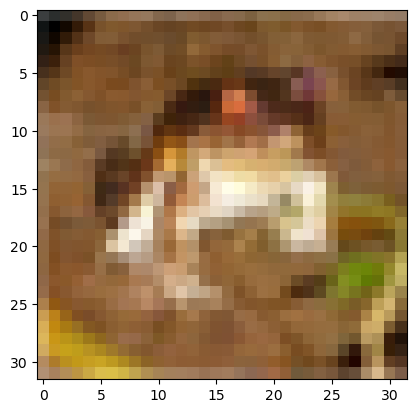

In [10]:
plt.imshow(trainset.data[0])
im,label = next(iter(trainloader))

In [11]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

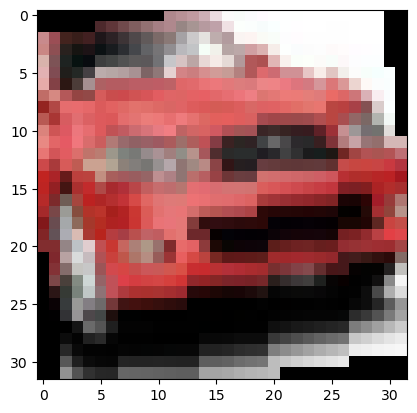

In [12]:
im[0].shape
imshow(im[0])

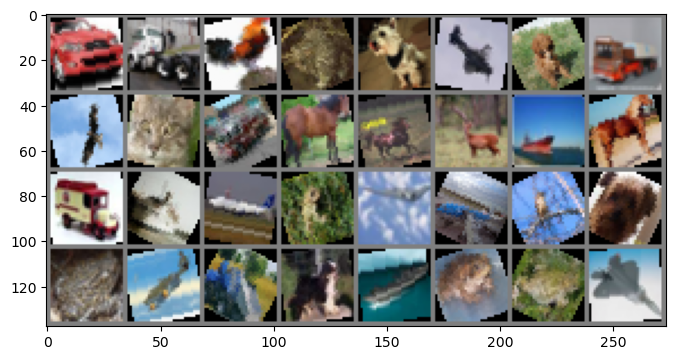

In [13]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))

In [14]:
#"""Bottleneck layers. Although each layer only produces k
#output feature-maps, it typically has many more inputs. It
#has been noted in [37, 11] that a 1×1 convolution can be in-
#troduced as bottleneck layer before each 3×3 convolution
#to reduce the number of input feature-maps, and thus to
#improve computational efficiency."""
class Bottleneck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        #"""In  our experiments, we let each 1×1 convolution 
        #produce 4k feature-maps."""
        inner_channel = 4 * growth_rate

        #"""We find this design especially effective for DenseNet and 
        #we refer to our network with such a bottleneck layer, i.e., 
        #to the BN-ReLU-Conv(1×1)-BN-ReLU-Conv(3×3) version of H ` , 
        #as DenseNet-B."""
        self.bottle_neck = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, inner_channel, kernel_size=1, bias=False),
            nn.BatchNorm2d(inner_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(inner_channel, growth_rate, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        return torch.cat([x, self.bottle_neck(x)], 1)

#"""We refer to layers between blocks as transition
#layers, which do convolution and pooling."""
class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        #"""The transition layers used in our experiments 
        #consist of a batch normalization layer and an 1×1 
        #convolutional layer followed by a 2×2 average pooling 
        #layer""".
        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.AvgPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.down_sample(x)

#DesneNet-BC
#B stands for bottleneck layer(BN-RELU-CONV(1x1)-BN-RELU-CONV(3x3))
#C stands for compression factor(0<=theta<=1)
class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_class=10):
        super().__init__()
        self.growth_rate = growth_rate

        #"""Before entering the first dense block, a convolution 
        #with 16 (or twice the growth rate for DenseNet-BC) 
        #output channels is performed on the input images."""
        inner_channels = 2 * growth_rate

        #For convolutional layers with kernel size 3×3, each 
        #side of the inputs is zero-padded by one pixel to keep 
        #the feature-map size fixed.
        self.conv1 = nn.Conv2d(3, inner_channels, kernel_size=3, padding=1, bias=False) 

        self.features = nn.Sequential()

        for index in range(len(nblocks) - 1):
            self.features.add_module("dense_block_layer_{}".format(index), self._make_dense_layers(block, inner_channels, nblocks[index]))
            inner_channels += growth_rate * nblocks[index]

            #"""If a dense block contains m feature-maps, we let the 
            #following transition layer generate θm output feature-
            #maps, where 0 < θ ≤ 1 is referred to as the compression 
            #fac-tor.
            out_channels = int(reduction * inner_channels) # int() will automatic floor the value
            self.features.add_module("transition_layer_{}".format(index), Transition(inner_channels, out_channels))
            inner_channels = out_channels

        self.features.add_module("dense_block{}".format(len(nblocks) - 1), self._make_dense_layers(block, inner_channels, nblocks[len(nblocks)-1]))
        inner_channels += growth_rate * nblocks[len(nblocks) - 1]
        self.features.add_module('bn', nn.BatchNorm2d(inner_channels))
        self.features.add_module('activation', nn.ReLU(inplace=True))

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.linear = nn.Linear(inner_channels, num_class)

    def forward(self, x):
        output = self.conv1(x)
        output = self.features(output)
        output = self.avgpool(output)
        output = output.view(output.size()[0], -1)
        output = self.linear(output)
        return output

    def _make_dense_layers(self, block, in_channels, nblocks):
        dense_block = nn.Sequential()
        for index in range(nblocks):
            dense_block.add_module('bottle_neck_layer_{}'.format(index), block(in_channels, self.growth_rate))
            in_channels += self.growth_rate
        return dense_block

def densenet121(activation = 'relu'):
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32)

def densenet169(activation = 'relu'):
    return DenseNet(Bottleneck, [6,12,32,32], growth_rate=32)

def densenet201(activation = 'relu'):
    return DenseNet(Bottleneck, [6,12,48,32], growth_rate=32)

def densenet161(activation = 'relu'):
    return DenseNet(Bottleneck, [6,12,36,24], growth_rate=48)

## DenseNet121 SGD

In [15]:
model = densenet121().to(device)

In [16]:
summary(model,(3,32,32))

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]           8,192
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]          36,864
        Bottleneck-8           [-1, 96, 32, 32]               0
       BatchNorm2d-9           [-1, 96, 32, 32]             192
             ReLU-10           [-1, 96, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]          12,288
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
           Conv2d-14           [-1, 32,

Initialize loss function and optimizer:

In [17]:
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, min_lr=1e-5) 

In [18]:
train_stats_list = []

In [ ]:
#train the model
def train(model, trainloader, testloader, epochs, optimizer , criterion , scheduler=None):
    
    # model.to(device)
    
    steps = 0
    running_loss = 0
    
    model.train()
    
    for epoch in range(epochs):
        
        since = time.time()
        
        train_accuracy = 0
        top3_train_accuracy = 0 
        for inputs, labels in trainloader:
            steps += 1
            # Move input and label tensors to the default device
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
            
            # calculate train top-1 accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # Calculate train top-3 accuracy
            np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
            target_numpy = labels.cpu().numpy()
            top3_train_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])


        if scheduler:
            scheduler.step(running_loss)
        
        test_loss = 0
        test_accuracy = 0
        top3_test_accuracy = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                logps = model.forward(inputs)
                batch_loss = criterion(logps, labels)
    
                test_loss += batch_loss.item()
    
                # Calculate test top-1 accuracy
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                
                # Calculate test top-3 accuracy
                np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
                target_numpy = labels.cpu().numpy()
                top3_test_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])

        time_elapsed = time.time() - since
    
        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Time per epoch: {time_elapsed:.4f}.. "
              f"Train loss: {running_loss/len(trainloader):.4f}.. "
              f"Train accuracy: {100.*(train_accuracy/len(trainloader)):.4f}.. "
              f"Test loss: {test_loss/len(testloader):.4f}.. "
              f"Test accuracy: {100.*(test_accuracy/len(testloader)):.4f}.. ")
        
        
        train_stats_list.append({'Epoch': epoch, 'Time per epoch':time_elapsed, 'Avg time per step': time_elapsed/len(trainloader), 'Train loss' : running_loss/len(trainloader), 'Train accuracy': train_accuracy/len(trainloader), 'Train top-3 accuracy':top3_train_accuracy/len(trainloader),'Test loss' : test_loss/len(testloader), 'Test accuracy': test_accuracy/len(testloader), 'Test top-3 accuracy':top3_test_accuracy/len(testloader)})
    
        running_loss = 0

    return train_stats_list

In [22]:
train(model, trainloader, testloader, epochs, optimizer , criterion , scheduler)

Epoch 1/50.. Time per epoch: 77.6889.. Train loss: 1.1428.. Train accuracy: 0.5920.. Test loss: 1.0409.. Test accuracy: 0.6344.. 
Epoch 2/50.. Time per epoch: 75.6133.. Train loss: 1.1803.. Train accuracy: 0.5740.. Test loss: 0.9526.. Test accuracy: 0.6655.. 
Epoch 3/50.. Time per epoch: 76.1941.. Train loss: 1.0055.. Train accuracy: 0.6410.. Test loss: 0.8420.. Test accuracy: 0.6919.. 
Epoch 4/50.. Time per epoch: 66.2357.. Train loss: 0.9034.. Train accuracy: 0.6803.. Test loss: 0.8402.. Test accuracy: 0.7048.. 
Epoch 5/50.. Time per epoch: 64.4817.. Train loss: 0.8278.. Train accuracy: 0.7064.. Test loss: 0.7614.. Test accuracy: 0.7302.. 
Epoch 6/50.. Time per epoch: 71.0643.. Train loss: 0.7614.. Train accuracy: 0.7296.. Test loss: 0.7523.. Test accuracy: 0.7411.. 
Epoch 7/50.. Time per epoch: 70.7733.. Train loss: 0.7100.. Train accuracy: 0.7503.. Test loss: 0.6602.. Test accuracy: 0.7660.. 
Epoch 8/50.. Time per epoch: 71.0747.. Train loss: 0.6590.. Train accuracy: 0.7671.. Test 

[{'Epoch': 0,
  'Time per epoch': 77.68887543678284,
  'Avg time per step': 0.09934638802657651,
  'Train loss': 1.1427782990438553,
  'Train accuracy': 0.5919916879795396,
  'Train top-3 accuracy': 0.8720628196930946,
  'Test loss': 1.0408650116556009,
  'Test accuracy': 0.6343550955414012,
  'Test top-3 accuracy': 0.8971934713375797},
 {'Epoch': 1,
  'Time per epoch': 75.6132881641388,
  'Avg time per step': 0.09669218435311866,
  'Train loss': 1.1803175031071733,
  'Train accuracy': 0.573968989769821,
  'Train top-3 accuracy': 0.8630714514066496,
  'Test loss': 0.9525500232247031,
  'Test accuracy': 0.6655055732484076,
  'Test top-3 accuracy': 0.9103304140127388},
 {'Epoch': 2,
  'Time per epoch': 76.1941168308258,
  'Avg time per step': 0.09743493200872866,
  'Train loss': 1.0054857025061117,
  'Train accuracy': 0.6410046355498721,
  'Train top-3 accuracy': 0.8967391304347826,
  'Test loss': 0.842009802153156,
  'Test accuracy': 0.6918789808917197,
  'Test top-3 accuracy': 0.927348

In [23]:
train_stats = pd.DataFrame(train_stats_list, columns = ['Epoch', 'Time per epoch', 'Avg time per step', 'Train loss', 'Train accuracy', 'Train top-3 accuracy','Test loss', 'Test accuracy', 'Test top-3 accuracy']) 

In [35]:
def plots(train_stats):
    fig = plt.figure(figsize=(10,7))
    ax = plt.axes()
    
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss");
    
    x = range(1, len(train_stats['Train loss'].values) + 1)
    ax.plot(x, train_stats['Train loss'].values, label='train loss');
    ax.plot(x, train_stats['Test loss'].values, label='test loss');
    
    plt.legend()


    fig = plt.figure(figsize=(10,7))
    ax = plt.axes()
    
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy");
    
    x = range(1, len(train_stats['Train accuracy'].values) + 1)
    ax.plot(x, train_stats['Train accuracy'].values, label='train accuracy');
    ax.plot(x, train_stats['Test accuracy'].values, label='test accuracy');
    
    plt.legend()

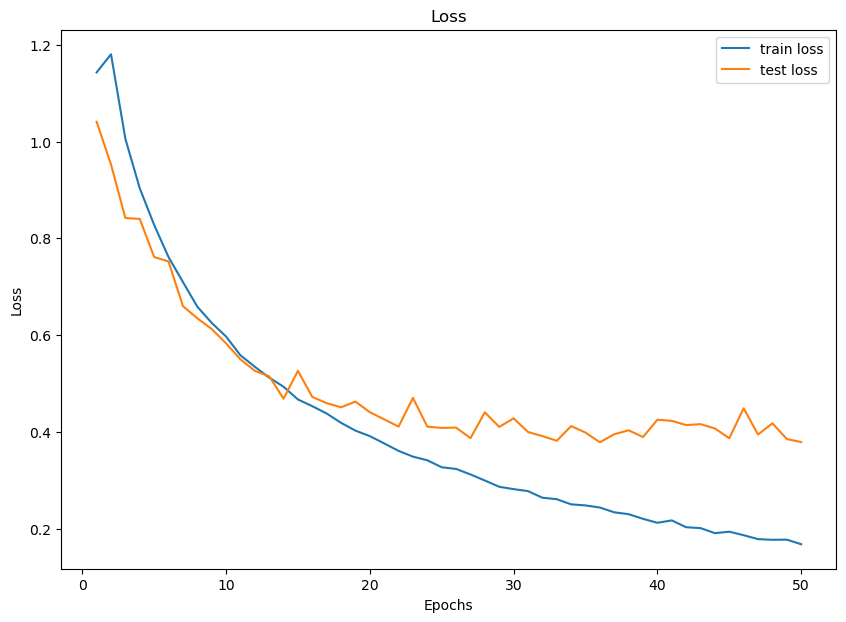

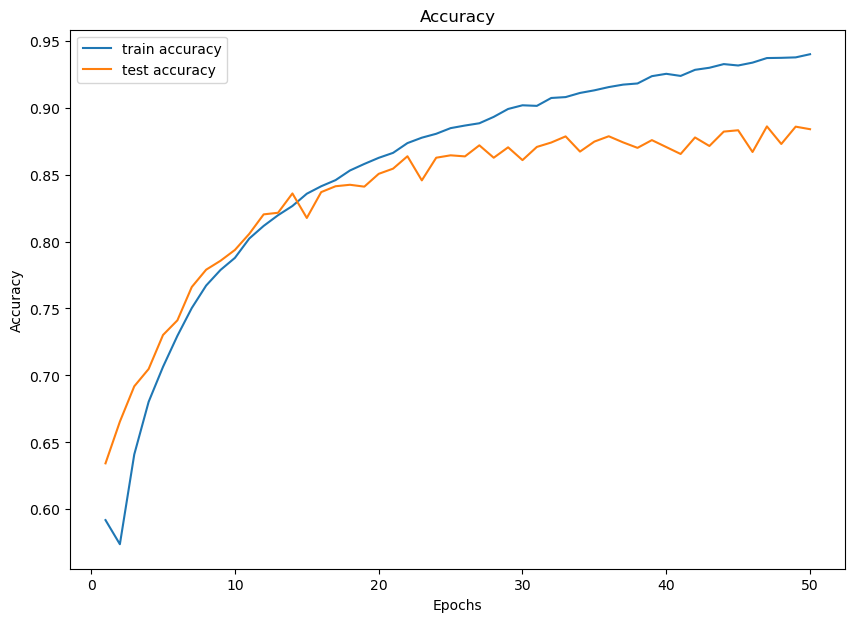

In [36]:
plots(train_stats)

In [37]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
torch.cuda.empty_cache()
model.eval()
with torch.no_grad():
    for data in testloader: # Loop through each batch
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        model.eval() # Convert the model to test mode
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = model(images) # Enter the network for testing

        # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # update the number of test images
        correct += (predicted == labels).sum() # update the number of correctly classified images

    print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 88.42 %


In [33]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 87.50 %
Accuracy of automobile : 94.60 %
Accuracy of  bird : 87.40 %
Accuracy of   cat : 84.20 %
Accuracy of  deer : 85.90 %
Accuracy of   dog : 79.20 %
Accuracy of  frog : 86.50 %
Accuracy of horse : 91.20 %
Accuracy of  ship : 95.20 %
Accuracy of truck : 92.50 %


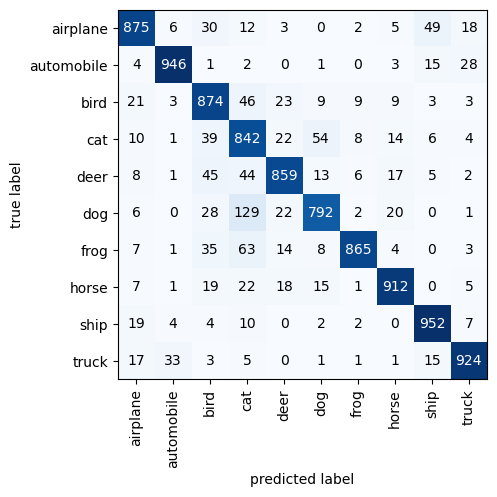

In [40]:
import numpy as np
from itertools import product


class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

from utils_cifar10 import compute_confusion_matrix, plot_confusion_matrix
mat = compute_confusion_matrix(model=model.to('cpu'), data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

Accuracy Rate = 84.375%


<Figure size 2500x400 with 0 Axes>

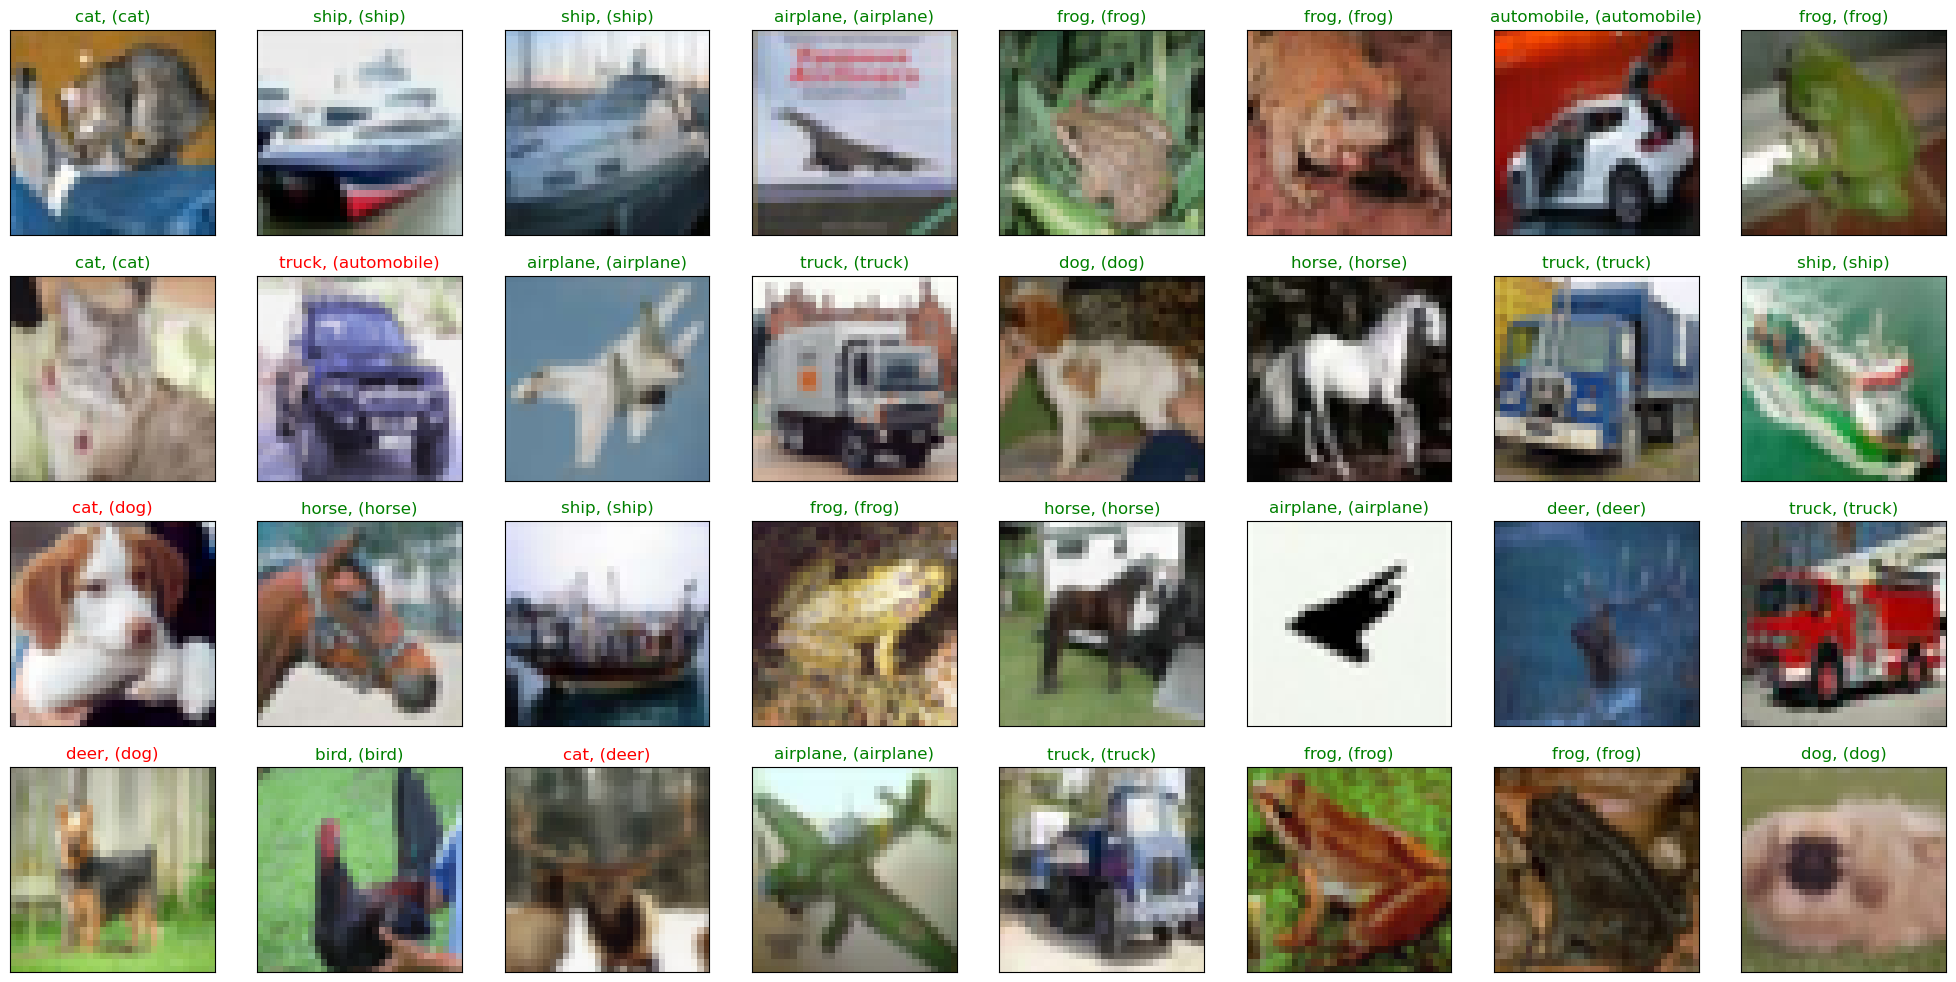

In [43]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_ = images
images_ = images_.to('cpu')
labels = labels.to('cpu')
val_output = model(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(32):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(
        "{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
        color = ("green" if val_preds[idx].item()==labels[idx].item() else "red")
    )

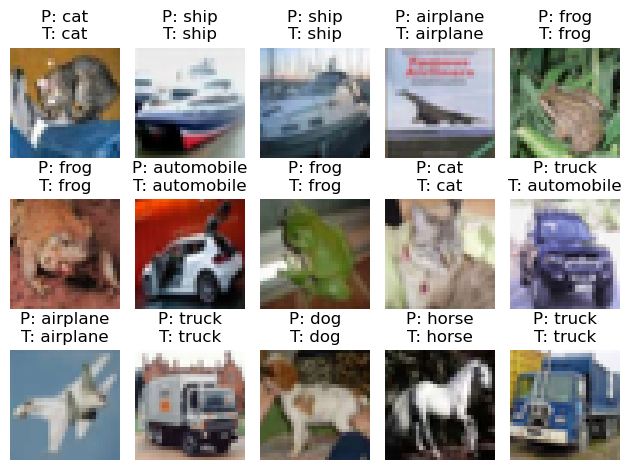

In [48]:
from utils_cifar10 import UnNormalize, show_examples

unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model, data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)

## DenseNet201 SGD

In [49]:
model = densenet201().to(device)

In [50]:
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]           8,192
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]          36,864
        Bottleneck-8           [-1, 96, 32, 32]               0
       BatchNorm2d-9           [-1, 96, 32, 32]             192
             ReLU-10           [-1, 96, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]          12,288
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
           Conv2d-14           [-1, 32,

Initialize loss function and optimizer:

In [51]:
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, min_lr=1e-5) 

In [52]:
train_stats_list = []

In [53]:
train(model, trainloader, testloader, epochs, optimizer , criterion , scheduler)

Epoch 1/50.. Time per epoch: 135.2989.. Train loss: 1.5091.. Train accuracy: 0.4528.. Test loss: 1.1766.. Test accuracy: 0.5735.. 
Epoch 2/50.. Time per epoch: 137.9074.. Train loss: 1.3186.. Train accuracy: 0.5218.. Test loss: 1.1972.. Test accuracy: 0.5676.. 
Epoch 3/50.. Time per epoch: 137.1845.. Train loss: 1.1004.. Train accuracy: 0.6059.. Test loss: 0.9934.. Test accuracy: 0.6349.. 
Epoch 4/50.. Time per epoch: 135.4618.. Train loss: 0.9884.. Train accuracy: 0.6490.. Test loss: 0.9227.. Test accuracy: 0.6733.. 
Epoch 5/50.. Time per epoch: 135.1905.. Train loss: 0.8981.. Train accuracy: 0.6803.. Test loss: 0.8175.. Test accuracy: 0.7120.. 
Epoch 6/50.. Time per epoch: 136.5327.. Train loss: 0.8238.. Train accuracy: 0.7060.. Test loss: 0.7353.. Test accuracy: 0.7388.. 
Epoch 7/50.. Time per epoch: 138.0781.. Train loss: 0.7632.. Train accuracy: 0.7291.. Test loss: 0.7502.. Test accuracy: 0.7339.. 
Epoch 8/50.. Time per epoch: 137.5475.. Train loss: 0.7103.. Train accuracy: 0.7477

[{'Epoch': 0,
  'Time per epoch': 135.29889750480652,
  'Avg time per step': 0.17301649297289837,
  'Train loss': 1.5091317326516447,
  'Train accuracy': 0.45282528772378516,
  'Train top-3 accuracy': 0.7816895780051151,
  'Test loss': 1.1766352402936122,
  'Test accuracy': 0.573546974522293,
  'Test top-3 accuracy': 0.8690286624203821},
 {'Epoch': 1,
  'Time per epoch': 137.90736174583435,
  'Avg time per step': 0.1763521249946731,
  'Train loss': 1.3186103879948101,
  'Train accuracy': 0.5218390345268542,
  'Train top-3 accuracy': 0.8320212595907929,
  'Test loss': 1.1971897805572316,
  'Test accuracy': 0.5675756369426752,
  'Test top-3 accuracy': 0.8652468152866242},
 {'Epoch': 2,
  'Time per epoch': 137.18451690673828,
  'Avg time per step': 0.17542777098048373,
  'Train loss': 1.1003530050635033,
  'Train accuracy': 0.6058583759590793,
  'Train top-3 accuracy': 0.8810342071611253,
  'Test loss': 0.9933917047871146,
  'Test accuracy': 0.6348527070063694,
  'Test top-3 accuracy': 0.

In [54]:
train_stats = pd.DataFrame(train_stats_list, columns = ['Epoch', 'Time per epoch', 'Avg time per step', 'Train loss', 'Train accuracy', 'Train top-3 accuracy','Test loss', 'Test accuracy', 'Test top-3 accuracy']) 

In [55]:
def plots(train_stats):
    fig = plt.figure(figsize=(10,7))
    ax = plt.axes()
    
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss");
    
    x = range(1, len(train_stats['Train loss'].values) + 1)
    ax.plot(x, train_stats['Train loss'].values, label='train loss');
    ax.plot(x, train_stats['Test loss'].values, label='test loss');
    
    plt.legend()


    fig = plt.figure(figsize=(10,7))
    ax = plt.axes()
    
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy");
    
    x = range(1, len(train_stats['Train accuracy'].values) + 1)
    ax.plot(x, train_stats['Train accuracy'].values, label='train accuracy');
    ax.plot(x, train_stats['Test accuracy'].values, label='test accuracy');
    
    plt.legend()

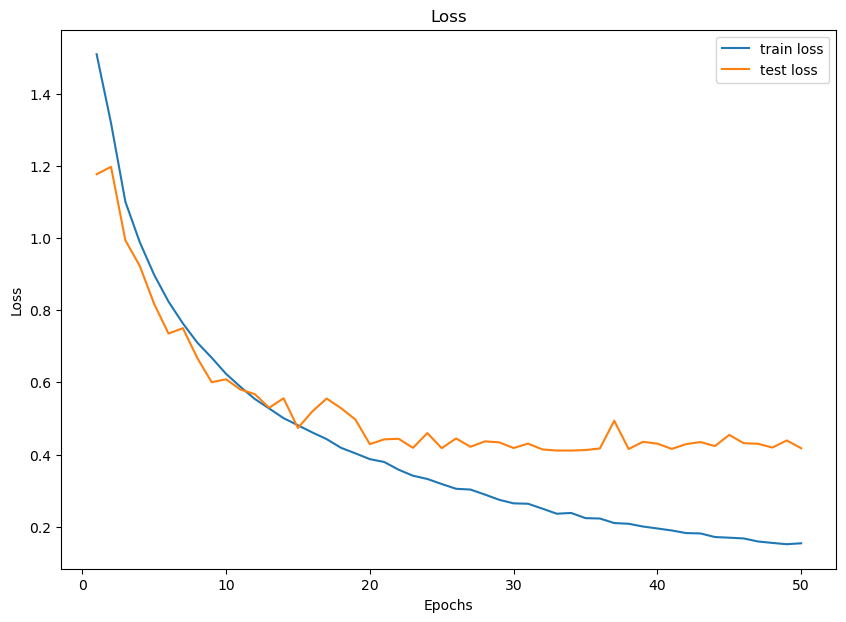

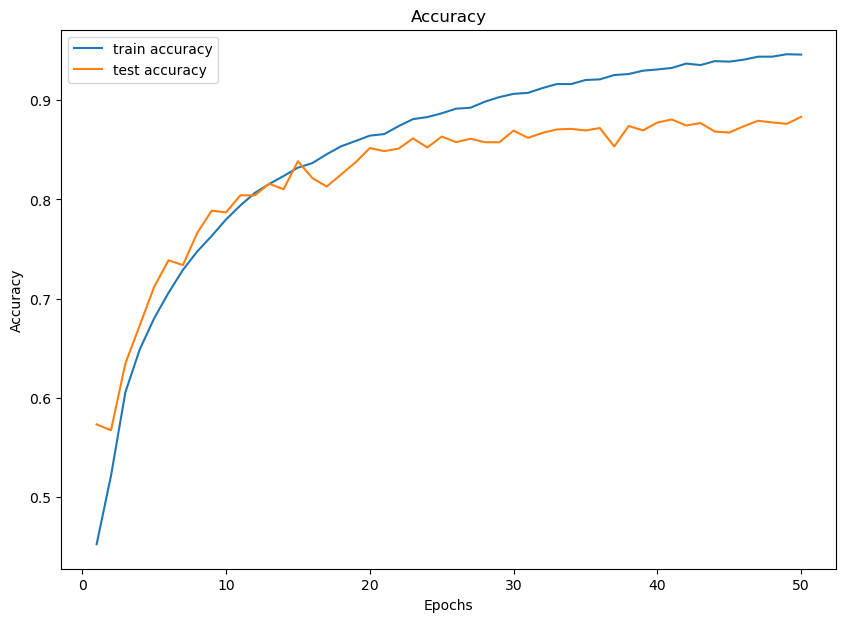

In [56]:
plots(train_stats)

In [57]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
torch.cuda.empty_cache()
model.eval()
with torch.no_grad():
    for data in testloader: # Loop through each batch
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        model.eval() # Convert the model to test mode
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = model(images) # Enter the network for testing

        # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # update the number of test images
        correct += (predicted == labels).sum() # update the number of correctly classified images

    print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 88.36 %


In [58]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 87.50 %
Accuracy of automobile : 93.10 %
Accuracy of  bird : 83.10 %
Accuracy of   cat : 82.00 %
Accuracy of  deer : 89.20 %
Accuracy of   dog : 85.30 %
Accuracy of  frog : 83.00 %
Accuracy of horse : 91.40 %
Accuracy of  ship : 95.90 %
Accuracy of truck : 93.10 %


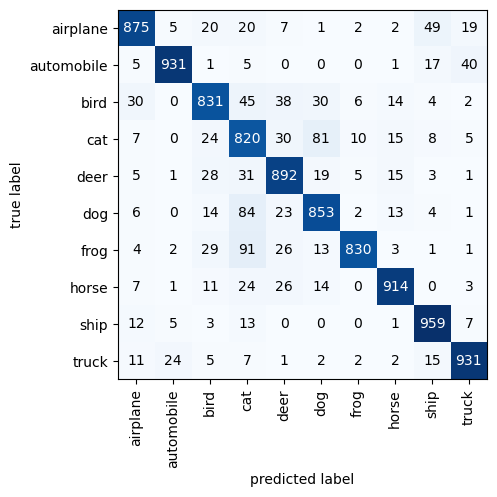

In [59]:
import numpy as np
from itertools import product


class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

from utils_cifar10 import compute_confusion_matrix, plot_confusion_matrix
mat = compute_confusion_matrix(model=model.to('cpu'), data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

Accuracy Rate = 87.5%


<Figure size 2500x400 with 0 Axes>

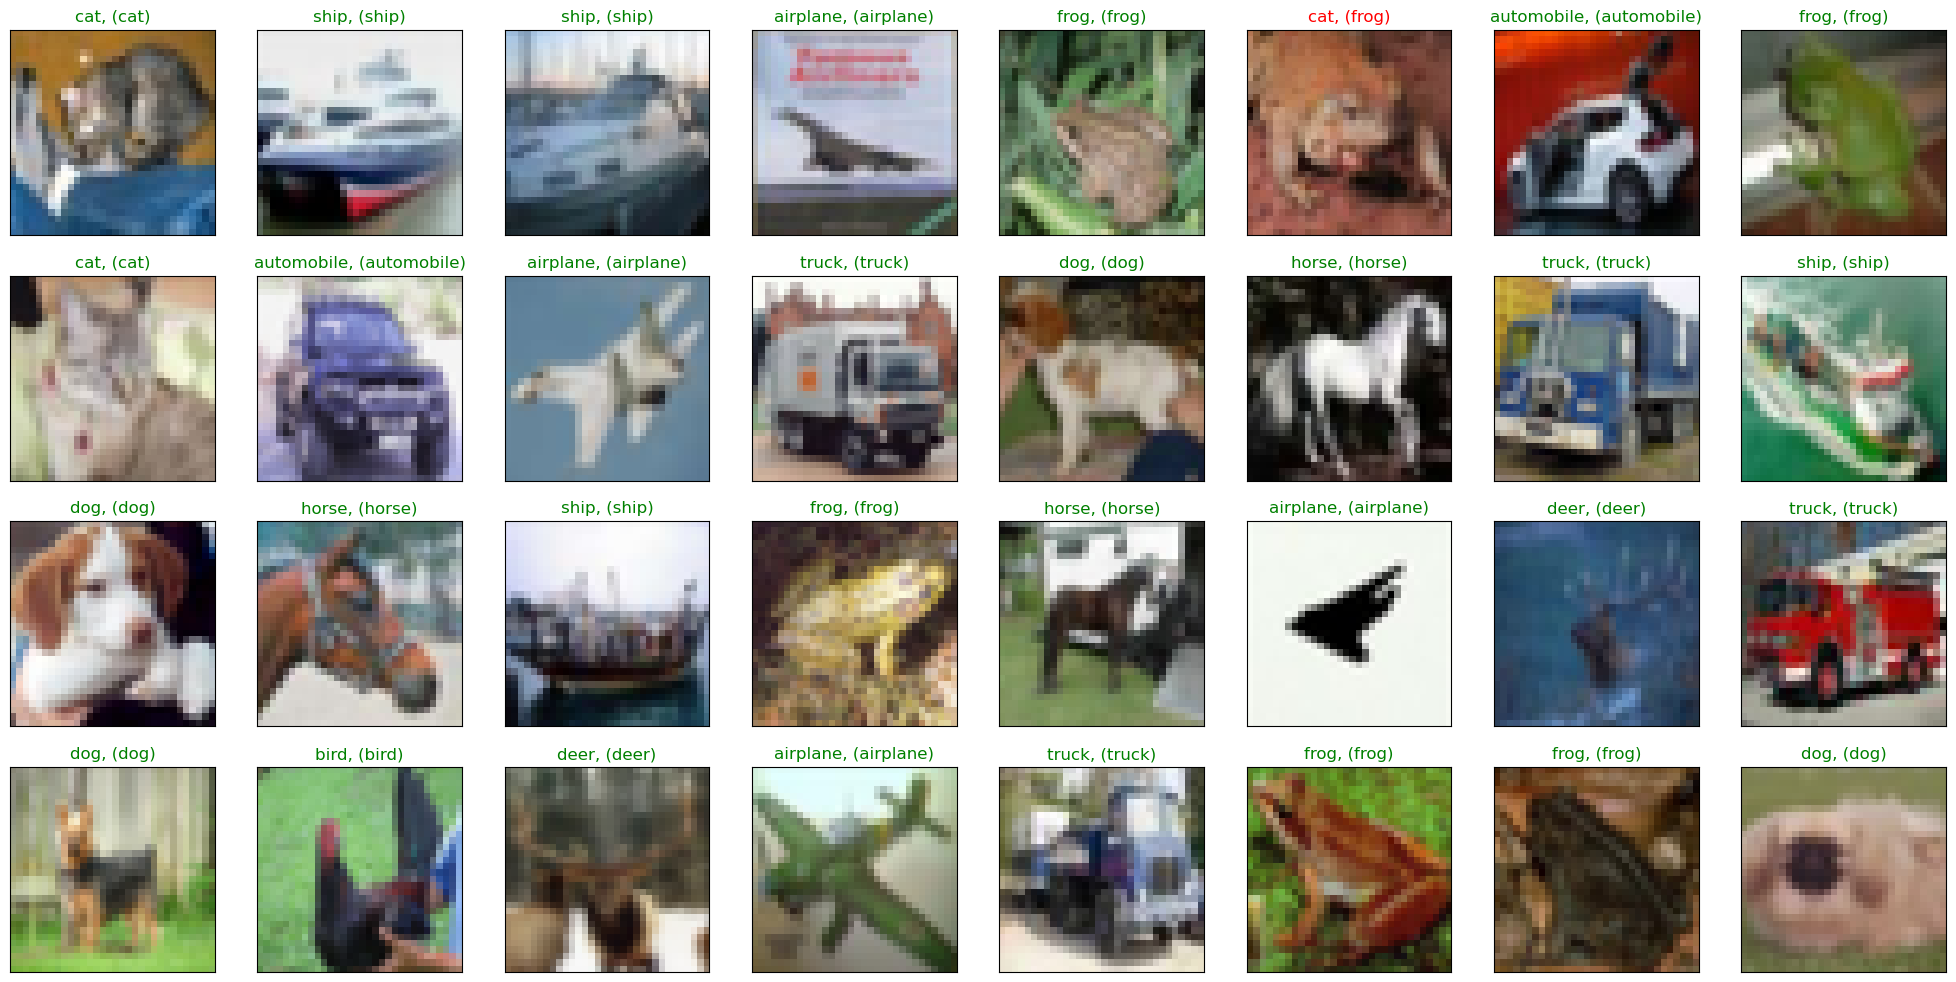

In [62]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_ = images
images_ = images_.to('cpu')
labels = labels.to('cpu')
val_output = model(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(32):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(
        "{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
        color = ("green" if val_preds[idx].item()==labels[idx].item() else "red")
    )

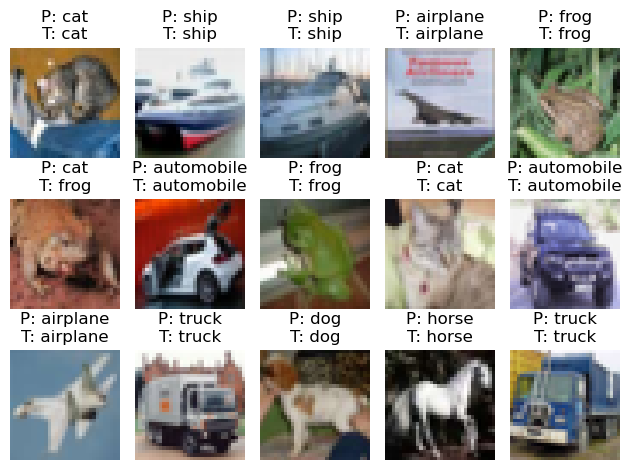

In [64]:
from utils_cifar10 import UnNormalize, show_examples

unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=model, data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)

## DenseNet201 Adam

In [65]:
model = densenet201().to(device)

In [66]:
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]           8,192
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]          36,864
        Bottleneck-8           [-1, 96, 32, 32]               0
       BatchNorm2d-9           [-1, 96, 32, 32]             192
             ReLU-10           [-1, 96, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]          12,288
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
           Conv2d-14           [-1, 32,

Initialize loss function and optimizer:

In [67]:
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [68]:
train_stats_list = []

In [69]:
train(model, trainloader, testloader, epochs, optimizer , criterion)

Epoch 1/50.. Time per epoch: 123.2948.. Train loss: 1.5582.. Train accuracy: 0.4255.. Test loss: 1.4352.. Test accuracy: 0.5010.. 
Epoch 2/50.. Time per epoch: 137.6636.. Train loss: 1.2749.. Train accuracy: 0.5354.. Test loss: 1.1495.. Test accuracy: 0.5766.. 
Epoch 3/50.. Time per epoch: 140.9266.. Train loss: 1.0730.. Train accuracy: 0.6154.. Test loss: 0.9281.. Test accuracy: 0.6715.. 
Epoch 4/50.. Time per epoch: 140.7580.. Train loss: 0.9588.. Train accuracy: 0.6584.. Test loss: 0.9374.. Test accuracy: 0.6657.. 
Epoch 5/50.. Time per epoch: 132.8550.. Train loss: 0.8637.. Train accuracy: 0.6916.. Test loss: 0.8484.. Test accuracy: 0.7028.. 
Epoch 6/50.. Time per epoch: 134.7125.. Train loss: 0.7837.. Train accuracy: 0.7228.. Test loss: 0.7953.. Test accuracy: 0.7375.. 
Epoch 7/50.. Time per epoch: 134.9306.. Train loss: 0.7183.. Train accuracy: 0.7478.. Test loss: 0.7094.. Test accuracy: 0.7552.. 
Epoch 8/50.. Time per epoch: 95.7536.. Train loss: 0.6649.. Train accuracy: 0.7662.

[{'Epoch': 0,
  'Time per epoch': 123.29479575157166,
  'Avg time per step': 0.15766597922195863,
  'Train loss': 1.5581907488958304,
  'Train accuracy': 0.42553148976982097,
  'Train top-3 accuracy': 0.7653053069053708,
  'Test loss': 1.435162578418756,
  'Test accuracy': 0.5009952229299363,
  'Test top-3 accuracy': 0.8192675159235668},
 {'Epoch': 1,
  'Time per epoch': 137.66361784934998,
  'Avg time per step': 0.17604043203241684,
  'Train loss': 1.2748954815175526,
  'Train accuracy': 0.535406010230179,
  'Train top-3 accuracy': 0.8437100383631714,
  'Test loss': 1.1495061812886767,
  'Test accuracy': 0.5766321656050956,
  'Test top-3 accuracy': 0.8767914012738853},
 {'Epoch': 2,
  'Time per epoch': 140.92664217948914,
  'Avg time per step': 0.18021309741622651,
  'Train loss': 1.0730390493827098,
  'Train accuracy': 0.615389226342711,
  'Train top-3 accuracy': 0.8852101982097187,
  'Test loss': 0.9280897861073731,
  'Test accuracy': 0.6714769108280255,
  'Test top-3 accuracy': 0.9

In [70]:
train_stats = pd.DataFrame(train_stats_list, columns = ['Epoch', 'Time per epoch', 'Avg time per step', 'Train loss', 'Train accuracy', 'Train top-3 accuracy','Test loss', 'Test accuracy', 'Test top-3 accuracy']) 

In [71]:
def plots(train_stats):
    fig = plt.figure(figsize=(10,7))
    ax = plt.axes()
    
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss");
    
    x = range(1, len(train_stats['Train loss'].values) + 1)
    ax.plot(x, train_stats['Train loss'].values, label='train loss');
    ax.plot(x, train_stats['Test loss'].values, label='test loss');
    
    plt.legend()


    fig = plt.figure(figsize=(10,7))
    ax = plt.axes()
    
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy");
    
    x = range(1, len(train_stats['Train accuracy'].values) + 1)
    ax.plot(x, train_stats['Train accuracy'].values, label='train accuracy');
    ax.plot(x, train_stats['Test accuracy'].values, label='test accuracy');
    
    plt.legend()

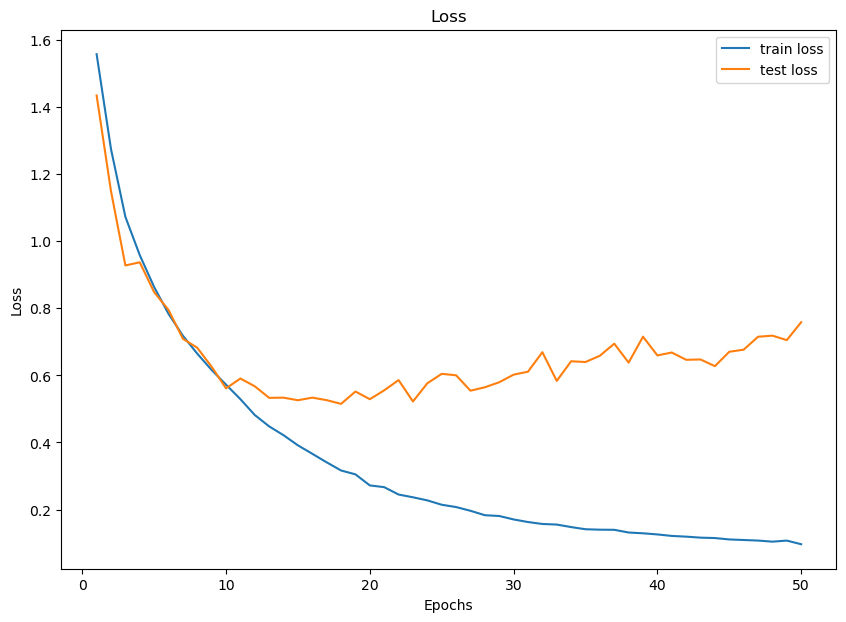

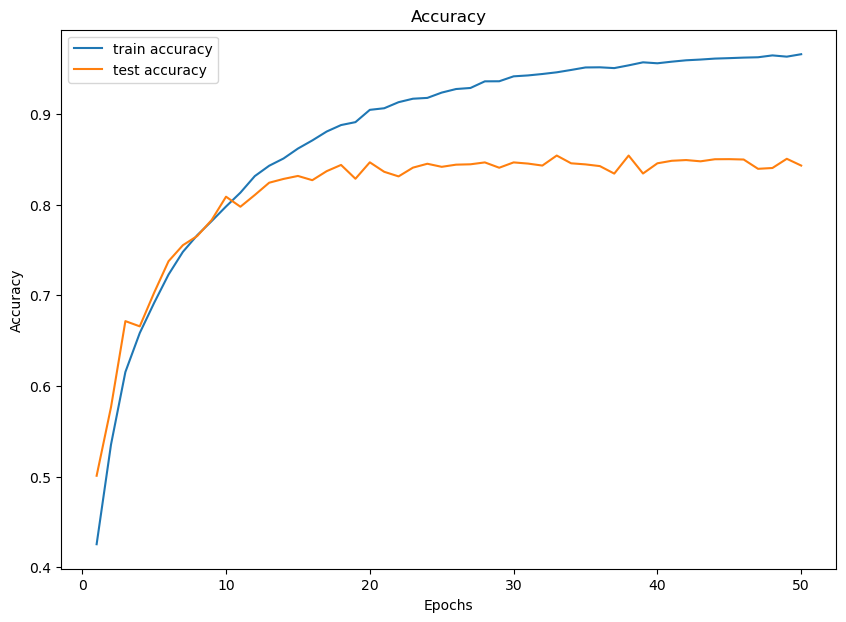

In [72]:
plots(train_stats)

In [73]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
torch.cuda.empty_cache()
model.eval()
with torch.no_grad():
    for data in testloader: # Loop through each batch
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        model.eval() # Convert the model to test mode
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = model(images) # Enter the network for testing

        # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # update the number of test images
        correct += (predicted == labels).sum() # update the number of correctly classified images

    print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 84.25 %


In [74]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 81.50 %
Accuracy of automobile : 93.10 %
Accuracy of  bird : 65.70 %
Accuracy of   cat : 67.20 %
Accuracy of  deer : 86.50 %
Accuracy of   dog : 84.30 %
Accuracy of  frog : 92.10 %
Accuracy of horse : 90.30 %
Accuracy of  ship : 90.60 %
Accuracy of truck : 91.20 %


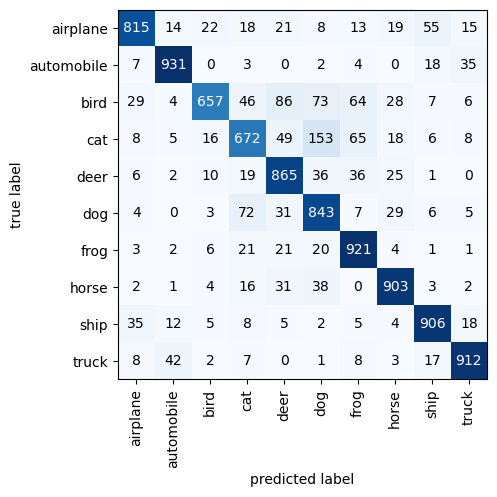

In [75]:
import numpy as np
from itertools import product


class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

from utils_cifar10 import compute_confusion_matrix, plot_confusion_matrix
mat = compute_confusion_matrix(model=model.to('cpu'), data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

Accuracy Rate = 81.25%


<Figure size 2500x400 with 0 Axes>

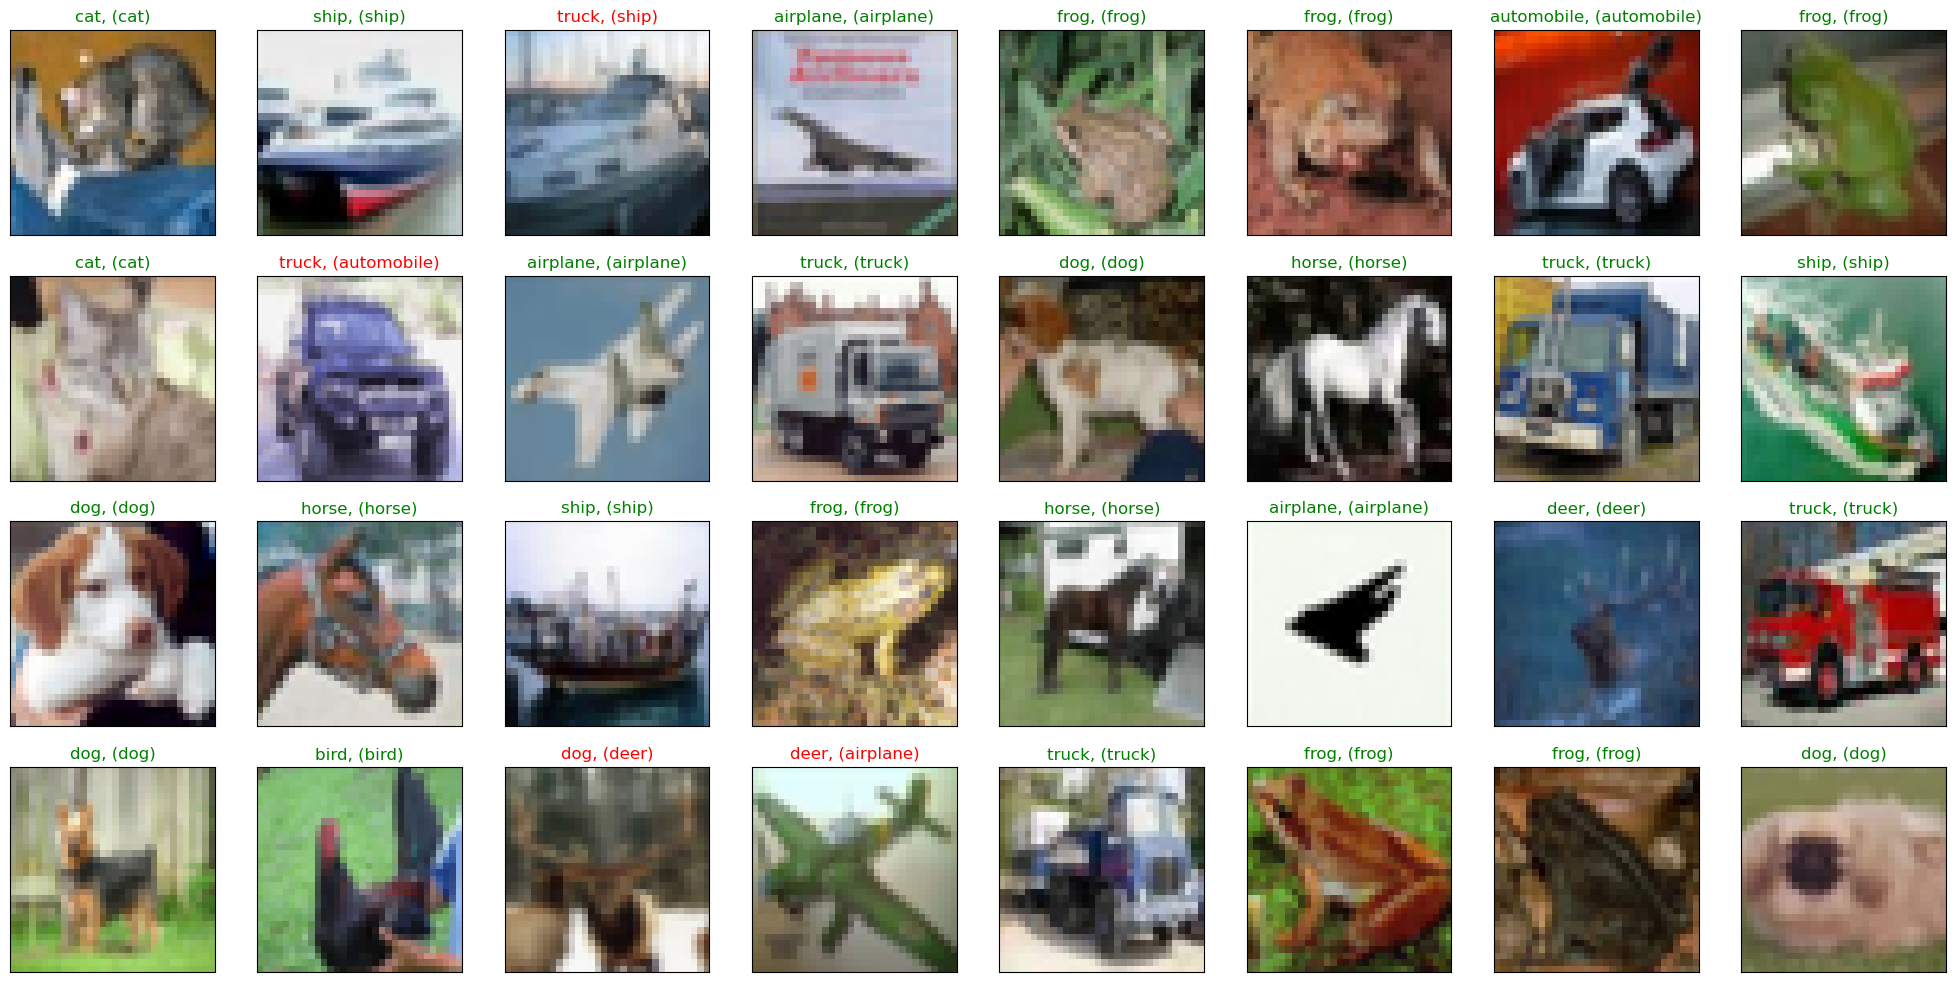

In [76]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_ = images
images_ = images_.to('cpu')
labels = labels.to('cpu')
val_output = model(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(32):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(
        "{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
        color = ("green" if val_preds[idx].item()==labels[idx].item() else "red")
    )

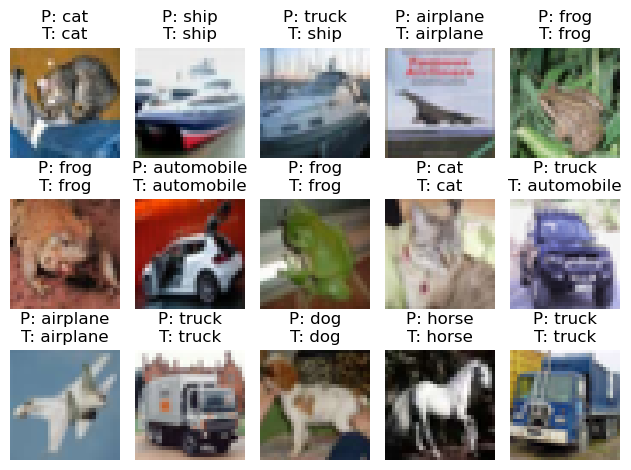

In [77]:
from utils_cifar10 import UnNormalize, show_examples

unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=model, data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)